In [1]:
"""

# Diabet bashorat qilish loyihasi

Ushbu loyihada Hindistonning Qandli diabet va buyrak kasalliklari milliy institutidan olingan ma'lumotlar to'plamidan foydalangan holda, diagnostik o'lchovlar asosida bemorda diabet bor-yo'qligini bashorat qilish vazifasi bajarilgan.

## 1. Ma'lumotlarni yuklab olish va tayyorlash

Dastlab, zarur kutubxonalar import qilinadi va ma'lumotlar to'plami yuklab olinadi.
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score


In [2]:
df = pd.read_csv('https://github.com/anvarnarz/praktikum_datasets/raw/main/diabetes.csv')

"""Ma'lumotlar to'plami haqida umumiy ma'lumot olish uchun `info()` va `head()` metodlari qo'llaniladi."""

df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
"""Ma'lumotlarning `Outcome` ustuni bilan korrelyatsiyasi aniqlanadi."""

df.corrwith(df['Outcome'])

,0
Pregnancies,0.221898
Glucose,0.466581
BloodPressure,0.065068
SkinThickness,0.074752
Insulin,0.130548
BMI,0.292695
DiabetesPedigreeFunction,0.173844
Age,0.238356
Outcome,1.000000


In [4]:
"""
Yangi xususiyatlar yaratish:

Bir nechta yangi xususiyatlar yaratish orqali modelning aniqligini oshirishga harakat qilamiz.
"""

df['Glucose_BMI'] = df['Glucose'] * df['BMI']
df['Glucose_Age'] = df['Glucose'] * df['Age']
df['BMI_Age'] = df['BMI'] * df['Age']
df['Glucose_BMI_interaction'] = df['Glucose'] * df['BMI'] * np.log(df['Age'] + 1)
df['Glucose_squared'] = df['Glucose'] ** 2
df['BMI_squared'] = df['BMI'] ** 2
df['Glucose_Age_squared'] = df['Glucose'] * df['Age'] ** 2
df['Log_Glucose'] = np.log(df['Glucose'] + 1)
df['Log_Age'] = np.log(df['Age'] + 1)
df['Age_BloodPressure'] = df['Age'] * df['BloodPressure']

In [5]:
"""Yangi xususiyatlar bilan korrelyatsiya qayta tekshiriladi."""

df.corrwith(df['Outcome'])

,0
Pregnancies,0.221898
Glucose,0.466581
BloodPressure,0.065068
SkinThickness,0.074752
Insulin,0.130548
BMI,0.292695
DiabetesPedigreeFunction,0.173844
Age,0.238356
Outcome,1.000000
Glucose_BMI,0.490262


In [6]:
"""
Ma'lumotlarni standartlash:

`StandardScaler` yordamida 'Glucose', 'BMI' va 'Age' ustunlari standartlashtiriladi.
"""

scaler = StandardScaler()
df[['Glucose', 'BMI', 'Age']] = scaler.fit_transform(df[['Glucose', 'BMI', 'Age']])

In [7]:
"""
PCA (Principal Component Analysis):

PCA yordamida 'Glucose', 'BMI' va 'Age' ustunlaridan yangi xususiyat yaratiladi.
"""

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df[['Glucose', 'BMI', 'Age']])
df['PCA_1'] = df_pca[:, 0]

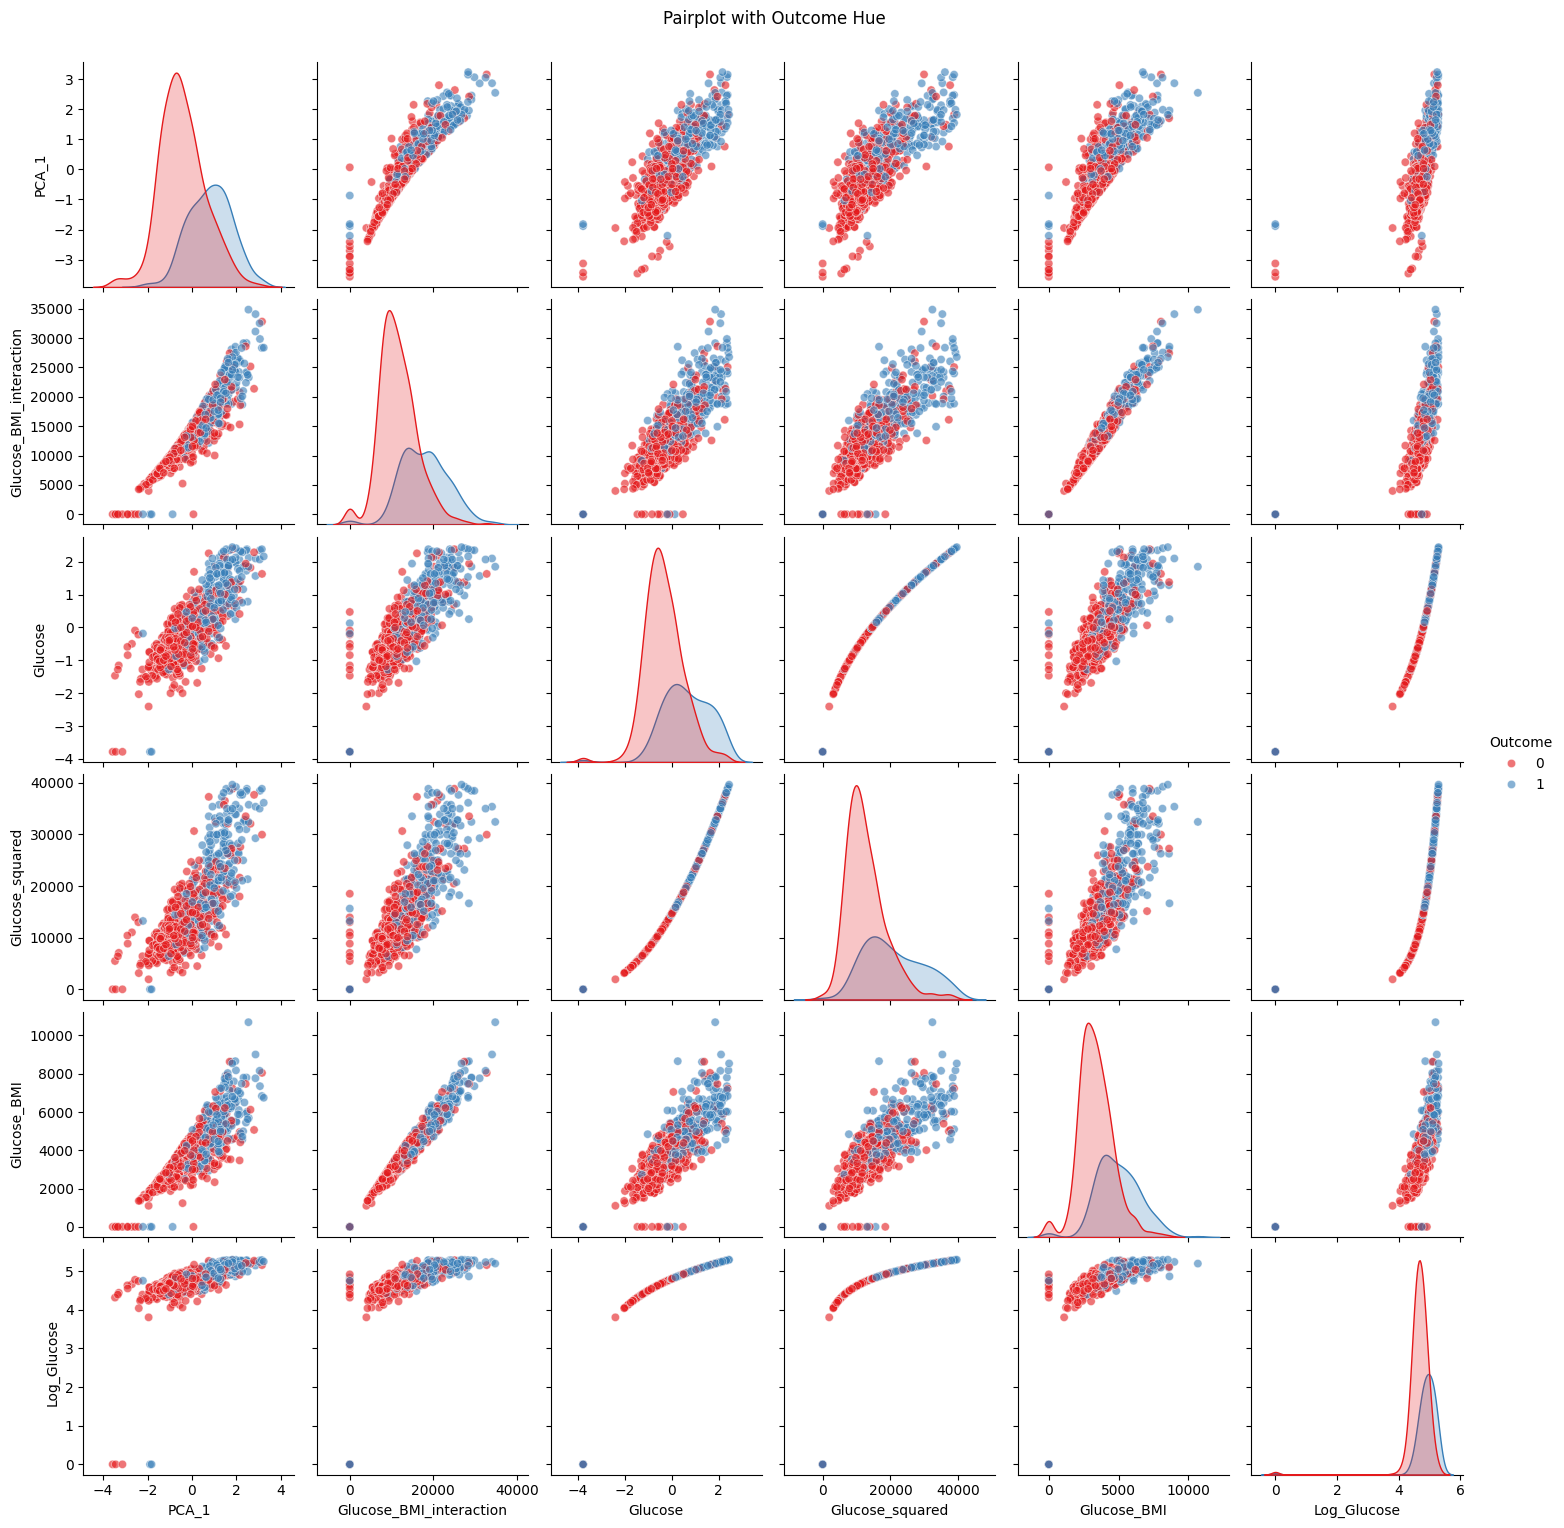

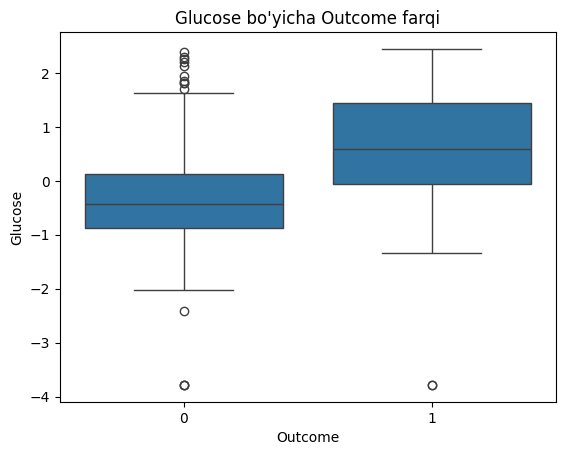

In [8]:
"""
Ma'lumotlarni vizualizatsiya qilish:

`pairplot` yordamida ma'lumotlarning tarqalishi vizualizatsiya qilinadi.
`boxplot` yordamida 'Glucose' va 'Outcome' o'rtasidagi bog'liqlik ko'rsatiladi.
"""

sns.pairplot(
    df[['PCA_1', 'Outcome', 'Glucose_BMI_interaction', 'Glucose', 'Glucose_squared', 'Glucose_BMI', 'Log_Glucose']],
    hue='Outcome',
    diag_kind='kde',
    palette='Set1',
    plot_kws={'alpha': 0.6}
)
plt.suptitle("Pairplot with Outcome Hue", y=1.02)
plt.show()

sns.boxplot(x='Outcome', y='Glucose', data=df)
plt.title("Glucose bo'yicha Outcome farqi")
plt.show()

In [9]:
"""
Etishmayotgan qiymatlarni to'ldirish:

`Log_Glucose` va `Log_Age` ustunlaridagi etishmayotgan qiymatlar o'rtacha qiymat bilan to'ldiriladi.
"""

mean_log_glucose = df['Log_Glucose'].mean()
df['Log_Glucose'].fillna(mean_log_glucose, inplace=True)
mean_log_age = df['Log_Age'].mean()
df['Log_Age'].fillna(mean_log_age, inplace=True)
print(df.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
Glucose_BMI                 0
Glucose_Age                 0
BMI_Age                     0
Glucose_BMI_interaction     0
Glucose_squared             0
BMI_squared                 0
Glucose_Age_squared         0
Log_Glucose                 0
Log_Age                     0
Age_BloodPressure           0
PCA_1                       0
dtype: int64


<ipython-input-9-f472c16b2ebf>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Log_Glucose'].fillna(mean_log_glucose, inplace=True)
<ipython-input-9-f472c16b2ebf>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

In [10]:
"""## 2. Modelni o'rgatish

Ma'lumotlarni o'qitish va test to'plamlariga ajratish.
"""

X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
"""Ma'lumotlarni standartlashtirish."""

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)